In [308]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import math
import PyUltraLight
import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from IPython.core.display import clear_output, display
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Custom Fancy Matplotlib Legend Handler and Settings

In [309]:
matplotlib.rcParams['animation.embed_limit'] = 2**128

from matplotlib.legend_handler import HandlerLine2D
import matplotlib.path as mpath
from matplotlib.transforms import BboxTransformFrom, BboxTransformTo, Bbox

font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}
matplotlib.rc('font', **font)

class HandlerMiniatureLine(HandlerLine2D):
    """Custom class handling the lines in matplotlib legends"""
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):
        
        #orig_handle.set_xdata(np.log10(orig_handle.get_xdata())) #PART ONE OF LOGPLOT, DELETE FOR LINEAR
        
        legline, _ = HandlerLine2D.create_artists(self,legend, orig_handle,
                                xdescent, ydescent, width, height, fontsize, trans, )
        legline.set_data(*orig_handle.get_data())
        ext = mpath.get_paths_extents([orig_handle.get_path()])
        if ext.width == 0:
            ext.x0 -= 0.1
            ext.x1 += 0.1
        bbox0 = BboxTransformFrom(ext)
        bbox1 = BboxTransformTo(Bbox.from_bounds(xdescent, ydescent, width, height))
        
        legline.set_transform(bbox0 + bbox1 + trans)
        #orig_handle.set_xdata(np.power(10,orig_handle.get_xdata())) #PART TWO OF LOGPLOT, DELETE FOR LINEAR
        return legline,

### Define Axion Mass, Physical Constants and Code Units

In [310]:
axion_mass = 1e-10 *1.783e-36 #kg

hbar = 1.0545718e-34  # m^2 kg/s
parsec = 3.0857e16  # m
light_year = 9.4607e15  # m
omega_m0 = 0.3111
omega_lambda = 0.6889
H_0 = 67.66 * 1e3 / (parsec * 1e6)   # s^-1
solar_mass = 1.989e30  # kg
G = 6.67e-11  # N m^2 kg^-2

length_unit = (8 * np.pi * hbar ** 2 / (3 * axion_mass ** 2 * H_0 ** 2 * omega_m0)) ** 0.25
time_unit = (3 * H_0 ** 2 * omega_m0 / (8 * np.pi)) ** -0.5
mass_unit = (3 * H_0 ** 2 * omega_m0 / (8 * np.pi)) ** 0.25 * hbar ** 1.5 / (axion_mass ** 1.5 * G)

### Set Simulation Parameters

In [311]:
# Set number of threads to target
num_threads = multiprocessing.cpu_count()
print('Number of threads = ',num_threads)


#choose whether you're varying ULDM particle mass(0), ellipticity/size(1), or rotation(2)
study = 0
#change ULDM particle mass
facs = [0.5, 0.75, 1.0, 1.25, 1.5] 
# facs = [1, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0] #(for larger ULDM mass range)
#change flattening
flat = [0, 0.25, 0.5, 0.75]
#change rotation
g = [0, 2.5, 5.0, 7.5, 10.0]
#change r^2 to change volume of ellipsoid
r2 = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

c_flat = 2 #choose 0 to 3 to select one of the possible flattenings above
c_g = 0 #choose 0 to 4 to select one of the possible rotation parameters above (g)
c_r2 = 3 #choose 0 to 5 to select one of the possible sizes above

# Set box size and resolution
# length = np.sqrt(1.) * 10. # 1 code unit is ~121 kpc x (1e-23/m_a)^0.5
length_units = ''  # Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units.
resol = 256 # It is recommended to check the upper bound on soliton mass for a given box size and resolution, should be even!
initial_z = 100. # redshift at simulation start - really just a measure of scale factor
final_z = 10.
central_mass = 0.
c_mass_unit = '' # Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units

#Data to save
save_rho = False # Saves density data for entire 3D simulation grid
save_psi = True # Saves full complex field data for entire 3D simulation grid
save_plane_z = True # Saves density data for plane z = 0
save_plane_x = True# Saves density data for plane x = 0
save_plane_y = True# Saves density data for plane y = 0
save_energies = True # Saves integrated gravitational, kinetic and total energies as lists, scalefactor aswell
save_lineyz = False # Saves density data for line y,z = 0. Useful for examining intereference patterns. 
save_linexy = False #Saves density data for line x,y = 0
save_linexz= False #Saves density data for line x,z = 0
save_psiplane_x = False
save_psiplane_y = False
save_psiplane_z = False

#Formats to save
hdf5 = False
npz = False
npy = True

skip_saves = 99.    # How many iterations are performed without saving data
save_path = 'Output'  # Set output directory

save_options = [save_rho,save_psi,save_plane_z,save_energies,
                save_lineyz,save_plane_x, save_plane_y, save_linexy, save_linexz,
                save_psiplane_x, save_psiplane_y, save_psiplane_z]

('Number of threads = ', 12)



### Set Initial Conditions:

In [312]:
#This function will be called to generate the initial psi-field
def initfunct(xarray,yarray,zarray):

    xs = np.zeros((resol,resol,resol))
    ys = np.zeros((resol,resol,resol))
    zs = np.zeros((resol,resol,resol))

    for i in range(resol):
        for j in range(resol):
            for k in range(resol):
                xs[i,j,k] = i
                ys[i,j,k] = j
                zs[i,j,k] = k
    
    
    R = resol * r2[c_r2] # Size of ellipsoid (R = r^2 in paper)
    delta = R/5.
    a_ = (1/(1-flat[c_flat]))**(1/3.)
    shp = [a_, a_, (1-flat[c_flat]) * a_] # Shape of ellipsoid
    dty = 50. # actually square root of rho, not physical density
    drop = .1 
    fac = 100  
    num = 1 # number of overdensities
     
    fld = pyfftw.zeros_aligned((resol, resol, resol), dtype='complex128')
    ext_bnd = int(max(shp)*np.sqrt(R))+1
    cents = [[],[],[]]
    
    for elem in cents:
        elem.append(np.random.randint(0+ext_bnd, resol-ext_bnd))
        while len(elem) < num: 
            val = np.random.randint(0+ext_bnd, resol-ext_bnd)
            for pres in elem:
                    if abs(pres - val) > 2*ext_bnd:
                        elem.append(val)
    
    theta = 1. # offset for rotation
        
    for i in range(num): 
        
        cents[0][i] = resol/2-1 
        cents[1][i] = resol/2-1 
        cents[2][i] = resol/2-1 
        
        x_pr = np.sin(theta)*ys + np.cos(theta)*xs
        y_pr = np.cos(theta)*ys - np.sin(theta)*xs  
        
        c_x_rot = np.sin(theta)*(resol/2.-1) + np.cos(theta)*(resol/2.-1)
        c_y_rot = np.cos(theta)*(resol/2.-1) - np.sin(theta)*(resol/2.-1)
        
        x_pr_pr = np.sin(theta)*zs + np.cos(theta)*x_pr
        z_pr = np.cos(theta)*zs - np.sin(theta)*x_pr  
        
        c_x_rot_rot = np.sin(theta)*(resol/2.-1) + np.cos(theta)*(c_x_rot)
        c_z_rot = np.cos(theta)*(resol/2.-1) - np.sin(theta)*(c_x_rot)
           
        region = np.where((x_pr_pr - c_x_rot_rot)**2/(shp[0]**2) + (y_pr - c_y_rot)**2/(shp[1]**2) + (z_pr - c_z_rot)**2/(shp[2]**2) <= R, dty, 0)
        fld = np.where((x_pr_pr - c_x_rot_rot)**2/(shp[0]**2) + (y_pr - c_y_rot)**2/(shp[1]**2) + (z_pr - c_z_rot)**2/(shp[2]**2) > R, dty*np.exp(-(drop*(abs(R - ((x_pr_pr - c_x_rot_rot)**2/(shp[0]**2) + (y_pr - c_y_rot)**2/(shp[1]**2) + (z_pr - c_z_rot)**2/(shp[2]**2)))))**2), 0)
        fld2 = np.where(fld > dty/fac, 1, 0)
        fld = fld * fld2
        fld = region + fld
        fld2 = np.where(fld <= dty/fac, dty/fac, 0)
        fld = fld + fld2


        
############### Introducing rotation below. Comment out or set first gauss_param to zero for no rotation
        

    gauss_param = [g[c_g], 0, .5]
    gridspace = float(length/float(resol))


    xvec = np.array([[np.linspace((0 - resol/2+1) * gridspace, (resol - (resol/2)) * gridspace, resol)]])
    yvec = xvec.reshape(resol,1, 1)
    zvec = xvec.reshape(1,resol,1)
    ell = np.sqrt(xvec**2/shp[0]**2 + yvec**2/shp[1]**2 + zvec**2/shp[2]**2)


    vec = np.array(np.linspace((0 - resol/2+1) * gridspace, (resol - (resol/2)) * gridspace, resol)).reshape(resol, 1)
    yplane = np.hstack([vec for i in range(resol)])
    fully = np.vstack([yplane for i in range(resol)]).reshape((resol,resol,resol))
    fullx = np.transpose(fully, (2, 0, 1))
    fullz = np.transpose(fully, (1, 0, 2))


    def gaussian(g, x):
        return g[0]*np.exp(-((x - g[1])**2/(2*g[2]**2)))

    vel = np.zeros((resol,resol,resol))
    bins = np.zeros(resol/2)
    bins[0] = 0
    bins[1] = gridspace/2
    for i in range(2,resol/2):
        bins[i] = bins[i-1] + gridspace
    for i in range(resol/2-1):
        ring = np.where(np.logical_and(bins[i] <= ell, ell < bins[i+1]), gaussian(gauss_param, (bins[i] + bins[i+1])/2), 0)
        vel = vel + ring


    fld = fld * np.exp(1j * vel)
    
    return fld

    


# Run:

In [313]:
locs = []
for i in range(len(facs)):
    length = np.sqrt(facs[i]) * 10
    step_factor = 1. / facs[i]
    PyUltraLight.evolve(central_mass, num_threads, length, length_units, resol, initial_z, final_z, step_factor, skip_saves, save_options, save_path, npz, npy, hdf5, initfunct, c_mass_unit)
    with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
        ts = timestamp.read()
        loc = save_path + '/' + ts
    locs.append(loc)



Complete.


# Mass loss over time:

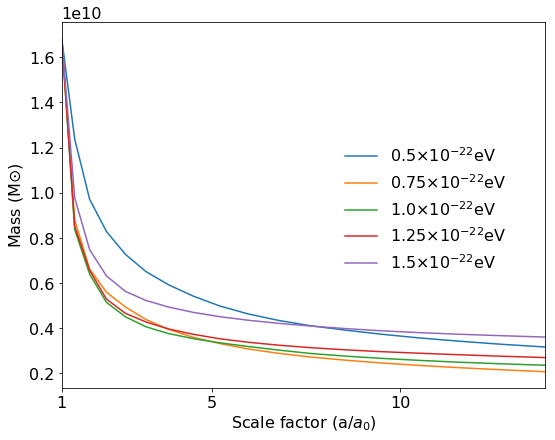

In [324]:
nm = len(facs)
mass_fac = []
mass = []
sf = np.load('{}{}'.format(locs[0], '/scalefactorlist.npy')).tolist()
for i in range(nm):
    mass_fac.append(7 * 10 ** 7 * (10**(-23)/(facs[i] * 10.**(-22)))**(3/2.))
    mass.append(np.load('{}{}'.format(locs[i], '/masslist.npy')).tolist())

for i in range(len(mass)):
    for j in range(len(mass[i])):
        mass[i][j] = mass[i][j] * mass_fac[i]

labs = []        
for i in range(len(facs)):        
        labs.append('{}{}'.format(facs[i],'$\\times 10^{-22}$eV'))

font = {'family': 'normal',
       'weight': 'normal',
       'size': '16'}
matplotlib.rc('font', **font)
plt.figure(figsize=(10,8))
for i in range(nm):
    plt.plot(sf, mass[i], label=labs[i])
plt.xlim(sf[0], sf[-1])
plt.xticks([1.0*sf[0], 5*sf[0], 10*sf[0]], [1, 5, 10]) ### Note: assumes full run
plt.xlabel('Scale factor (a/$a_0$)' )
plt.ylabel('Mass (M$\odot$)')
plt.tight_layout(rect=[0,0.2,0.8,1])
plt.legend(frameon=False, bbox_to_anchor=(0.95, 0.7), loc='upper right', fontsize=9, ncol=1, prop={'size': 16})
my_path = os.path.abspath('Figures')
plt.savefig(my_path + '/mass_loss_ULDM_mass_ltd.png', )
plt.show()


# Final spherical average density profiles:

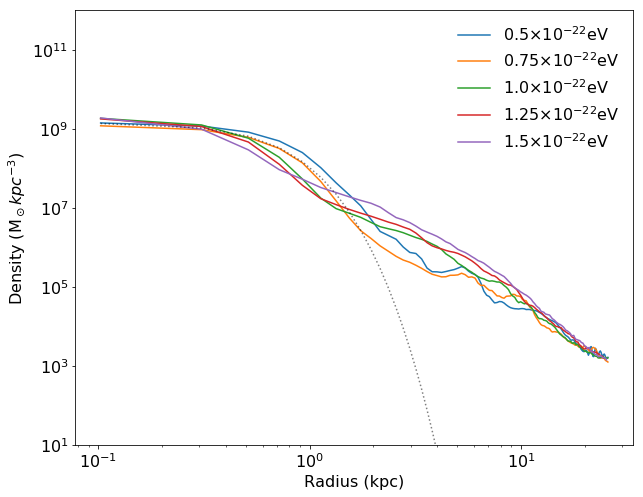

In [316]:
nm = len(facs)
scales = []
for i in range(nm):
    L = (121 * (10**(-23)/(facs[i]*10**(-22)))**(.5))
    M = 7 * 10 ** 7 * (10**(-23)/(facs[i]*10**(-22)))**(3/2.)
    dens = M/L**3
    scales.append([L, dens])
    
sf = np.load('{}{}'.format(locs[0], '/scalefactorlist.npy')).tolist()
profile_num = len(sf) - 1
a_f = sf[profile_num]
data = []
for i in range(nm):
    fil = np.load('{}{}{}{}'.format(locs[i], '/psi_#', profile_num, '.npy'))
    data.append((np.abs(fil)**2 * scales[i][1]) / a_f**3)
    
gridspace = np.sqrt(facs[0]) * 10 * scales[0][0] * a_f/float(resol) # Physical distance
    
# Find halo centres and truncate if displaced
cents = []
max_dens = []
truncs = []
for i in range(nm):
    centre = np.unravel_index(np.argmax(data[i]), data[i].shape)
    max_den = data[i][centre]
    trunc = min(resol-centre[0], centre[0], resol-centre[1], centre[1], centre[2], resol-centre[2])
    cents.append(centre)
    max_dens.append(max_den)
    truncs.append(trunc)

# Setting up x, y, z vectors to determine radial distance from centre of halo
vecs = []
for centre in cents:
    xvec = np.array([[np.linspace((0 - centre[0]) * gridspace, (resol - (centre[0]+1)) * gridspace, resol)]]).reshape(resol,1, 1)
    yvec = np.array([[np.linspace((0 - centre[1]) * gridspace, (resol - (centre[1]+1)) * gridspace, resol)]]).reshape(1,resol,1)
    zvec = np.array([[np.linspace((0 - centre[2]) * gridspace, (resol - (centre[2]+1)) * gridspace, resol)]])
    rvals = np.sqrt(xvec ** 2 + yvec ** 2 + zvec ** 2)
    vecs.append([xvec, yvec, zvec, rvals])

#### Binning distances and calculation of the spherical averages
avgs = []
for i in range(nm):
    bins = np.zeros(truncs[i] + 1)
    bins[0] = 0
    bins[1] = gridspace/2
    for k in range(2,truncs[i] + 1):
        bins[k] = bins[k-1] + gridspace
    avg = np.zeros(truncs[i])
    for j in range(int(truncs[i])):
        avg[j] = np.average(data[i][np.logical_and(bins[j] <= vecs[i][3], vecs[i][3] < bins[j+1])])
    avg = avg.tolist()
    bins = bins.tolist()
    bins.pop(0)
    avgs.append([avg, bins])


soliton = np.load('soliton.npy')

sol_d_phys = soliton[0]**2 * scales[0][1]
sol_gs_phys = (9/900000.) * scales[0][0]
sol_len_phys = 9 * scales[0][0]

alpha = np.sqrt(avgs[0][0][0]/sol_d_phys)
sol = []
for i in range(len(avgs[0][0])):
    if np.sqrt(alpha) * avgs[0][1][i] < sol_len_phys:
        sol.append((alpha * soliton[int(np.sqrt(alpha) * avgs[0][1][i] / sol_gs_phys)])**2 * scales[0][1])
    else:
        sol.append(0)

    
# Plotting
plt.figure(figsize=(10,8))
for i in range(nm):
    plt.loglog(avgs[i][1], avgs[i][0], label=labs[i])
plt.loglog(avgs[0][1], sol, color='k', linestyle=':', alpha=0.5)
plt.ylim(10**1, 10**12)    ### Note: plot limits may need to be changed if input params are changed
# plt.xlim(3*10**(-1), 7*10**1)
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M$_\odot kpc^{-3}$)')
plt.legend(frameon=False)
plt.show()



# Animation of density contours:

In [317]:
# Choose which ULDM particle mass (0, 1, 2, 3, 4) --> facs = [1.0, 2.5, 5.0, 7.5, 10.0]
mss = 0

plot_axis = 'z' #axis that is set to zero
plt.ioff()
fig0, ax0 = plt.subplots(figsize=(20, 10), dpi=50)
ax0.set_aspect('equal')

save_number = np.size(np.load('{}{}'.format(locs[mss], '/masslist.npy')).tolist())-1
scalefactorlist = np.load('{}{}'.format(locs[mss], '/scalefactorlist.npy'))
data0 = []
for x in np.arange(0,save_number+1,1):     
    data0.append(np.log10(np.load('{}{}{}{}{}{}'.format(locs[mss], '/plane', plot_axis, '_#', x, '.npy'))))
planemax = np.max(data0)
planemin = np.min(data0)
levels = np.linspace(planemin, planemax, 50)

def animate0(i):
    ax0.cla()
    ax0.set_aspect('equal')
    ax0.get_xaxis().set_ticks([])
    ax0.get_yaxis().set_ticks([])
    #ax0.contour(data0[i], levels=levels, vmin=planemin, vmax=planemax)
    ax0.imshow(data0[i])
    fig0.suptitle('{}{}{}'.format('Logarithmic Mass Density - plane ', plot_axis, '=0'), fontsize = 15)
    ax0.text(0.90, 1.1, '{}{}'.format('Output ', i), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)
    ax0.text(0.90, 1.05, '{}{}'.format(r'$a \approx$ ', np.around(scalefactorlist[i],4)), horizontalalignment='center', verticalalignment='center', transform=ax0.transAxes)

interval = 0.5 #in seconds
ani0 = matplotlib.animation.FuncAnimation(fig0,animate0,save_number+1,interval=interval*1e+3,blit=False)
from IPython.display import HTML
animated_plot0 = HTML(ani0.to_jshtml())


fig0.clear()
display(animated_plot0) 

<Figure size 1000x500 with 0 Axes>

# Density Contours: 

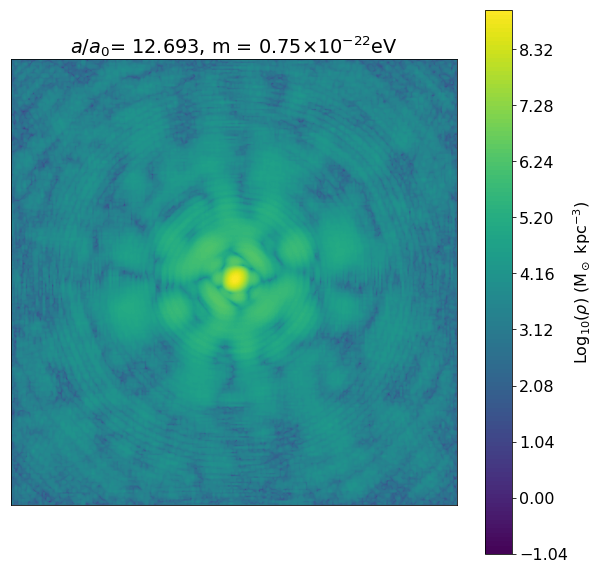

In [318]:
# Choose which saved output number to plot
profile_num = len(sf) - 2
# Choose which ULDM particle mass (0, 1, 2, 3, 4) --> facs = [1.0, 2.5, 5.0, 7.5, 10.0]
mss = 1


sf = np.load('{}{}'.format(locs[mss], '/scalefactorlist.npy')).tolist()
a0 = sf[0]
profile_num_max = len(sf) - 1
nm = len(facs)
scales = []
for i in range(nm):
    L = (121 * (10**(-23)/(facs[i]*10**(-22)))**(.5))
    M = 7 * 10 ** 7 * (10**(-23)/(facs[i]*10**(-22)))**(3/2.)
    dens = M/L**3
    scales.append([L, dens])

a_f = sf[profile_num]
data = []
for i in range(nm):
    fil = np.load('{}{}{}{}'.format(locs[i], '/planex_#', profile_num, '.npy'))
    data.append(np.log10((fil * scales[i][1]) / a_f**3))

N = 150
plt.figure(figsize=(10,10))
plt.contourf(data[mss], N)
plt.axes().set_aspect('equal')
plt.colorbar(label='Log$_{10}$($\\rho$) (M$_\odot$ kpc$^{-3}$)')
plt.xticks([])
plt.yticks([])
plt.title('{}{}{}{}{}'.format('$a/a_0$= ', np.round(a_f/a0,3), ', m = ', facs[mss], '$\\times 10^{-22}$eV'))
plt.show()

# Probability distributions of TTT eigenvalues:

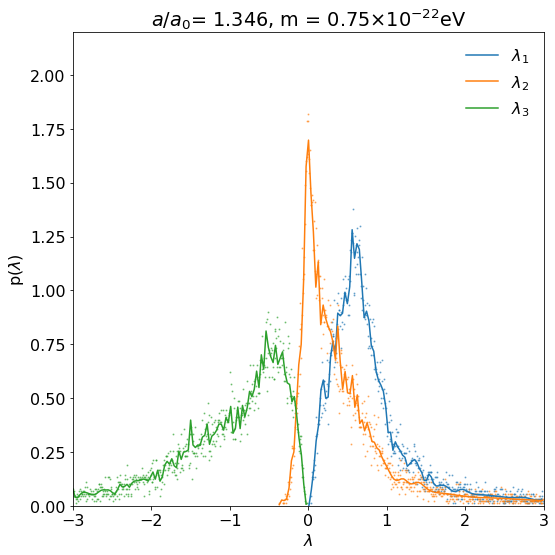

In [319]:
# Choose which saved output number to plot
profile_num = 1
# Choose which ULDM particle mass (0, 1, 2, 3, 4) --> facs = [1.0, 2.5, 5.0, 7.5, 10.0]
mss = 1

sf = np.load('{}{}'.format(locs[mss], '/scalefactorlist.npy')).tolist()
a0 = sf[0]
a_f = sf[profile_num]

import random
gridlength = 10.
n_samples = 15000
dnty = np.load('{}{}{}{}'.format(locs[mss], '/psi_#', profile_num, '.npy'))
dnty = np.abs(dnty)**2
delta = (dnty - np.average(dnty))/np.average(dnty)
resol = np.shape(dnty)[0]

# SET UP THE REAL SPACE COORDINATES OF THE GRID
gridvec = np.linspace(-gridlength / 2.0 + gridlength / float(2 * resol), gridlength / 2.0 - gridlength / float(2 * resol), resol)
xarray, yarray, zarray = np.meshgrid(gridvec, gridvec, gridvec, sparse=True, indexing='ij')
# distarray = ne.evaluate("(xarray**2+yarray**2+zarray**2)**0.5") # Radial coordinates

# SET UP K-SPACE FOR RHO (REAL)
rkvec = 2 * np.pi * np.fft.fftfreq(resol, gridlength / float(resol))
krealvec = 2 * np.pi * np.fft.rfftfreq(resol, gridlength / float(resol))
rkxarray, rkyarray, rkzarray = np.meshgrid(rkvec, rkvec, krealvec, sparse=True, indexing='ij')
rkarray2 = rkxarray**2+rkyarray**2+rkzarray**2

# FIND FOURIER SPACE OVERDENSITY
rfft_delta = pyfftw.builders.rfftn(delta, axes=(0, 1, 2)) #Doesn't ever refer to  real space coords
delta_k = rfft_delta(delta)
# irfft_funct = pyfftw.builders.irfftn(rkarray2, axes=(0, 1, 2))
phi_k = delta_k*(rkarray2**-1)
phi_k[0,0,0] = 0.

Tidal_k = dict([])
k_vals = dict([(0,rkxarray),(1,rkyarray),(2, rkzarray)])
for i in range(3):
    for j in range(3):
        Tidal_k['{}{}{}'.format('Tk_', i, j)] = k_vals[i]*k_vals[j]*phi_k

# MAKE IT TRACELESS
for i in range(3):
    for j in range(3):
        if i == j:
            Tidal_k['{}{}{}'.format('Tk_', i, j)] = Tidal_k['{}{}{}'.format('Tk_', i, j)] - delta_k/3.
        else:
            Tidal_k['{}{}{}'.format('Tk_', i, j)] = Tidal_k['{}{}{}'.format('Tk_', i, j)]

Tidal = dict([])
irfft_funct = pyfftw.builders.irfftn(rkarray2, axes=(0, 1, 2))
cnt = -1
lst = []
for i in range(3):
    for j in range(3):
        cnt = cnt + 1
        lst.append(irfft_funct(Tidal_k['{}{}{}'.format('Tk_', i, j)]).copy())
ind_list = []
for i in range(resol):
    for j in range(resol):
        for k in range(resol):
            ind_list.append([i,j,k])
sample_list = random.sample(ind_list, n_samples)
results = []
for a in sample_list:
    matrx = np.zeros((3, 3))
    cnt = -1
    for i in range(3):
        for j in range(3):
            cnt = cnt + 1
            arr = lst[cnt]
            matrx[i][j] = np.real(arr[a[0], a[1], a[2]])
    diag = np.linalg.eig(matrx)
    new = np.real(diag[0]).tolist()
    if new[0] == 0 and new[1] == 0 and new[2] == 0:
        print 'All eigenvalues zero'
    else:
        sml = new.index(min(new))
        lge = new.index(max(new))
        ord = [0,1,2]
        ord.remove(sml)
        ord.remove(lge)
        mid = ord[0]
        new = [[diag[0][lge],diag[1][lge]], [diag[0][mid],diag[1][mid]], [diag[0][sml],diag[1][sml]], a, delta[a[0], a[1], a[2]]]
        results.append(new)
results.append(resol)
tot = len(results)-1
tot_1 = tot
tot_2 = tot
tot_3 = tot

rem_zeros = 0

lambda_1 = []
lambda_2 = []
lambda_3 = []

for i in range(tot):
    lambda_1.append(np.real(results[i][0][0]))
    lambda_2.append(np.real(results[i][1][0]))
    lambda_3.append(np.real(results[i][2][0]))

count = 0
for item in lambda_1:
    if item < 10**(-1):
        count = count +1

########################## TO REMOVE ZERO VALUES
if rem_zeros == 1:
    lambda_1_new = []
    for item in lambda_1:
        if abs(np.around(item, 6)) != 0.0:
            lambda_1_new.append(item)
    tot_1 = len(lambda_1_new)
    lambda_2_new = []
    for item in lambda_2:
        if abs(np.around(item, 6)) != 0.0:
            lambda_2_new.append(item)
    tot_2 = len(lambda_2_new)
    if tot_2 == 0:
        print 'Warning - all lambda_2 values zero'
    lambda_3_new = []
    for item in lambda_3:
        if abs(np.around(item, 6)) != 0.0:
            lambda_3_new.append(item)
    tot_3 = len(lambda_3_new)
else:
    lambda_1_new = lambda_1
    lambda_2_new = lambda_2
    lambda_3_new = lambda_3

n_bins = 1000
bins = np.zeros(n_bins)
rge = 6
delta = rge/float(n_bins-1)
bins[0] = -3
list = []
for i in range(1, n_bins):
    bins[i] = bins[i - 1] + delta


prob_1 = np.zeros(n_bins)
prob_2 = np.zeros(n_bins)
prob_3 = np.zeros(n_bins)
for i in range(n_bins-1):
    prob_1[i] = np.count_nonzero(np.logical_and(bins[i] <= lambda_1_new, lambda_1_new < bins[i+1]))/(tot_1*delta)
    if tot_2 != 0:
        prob_2[i] = np.count_nonzero(np.logical_and(bins[i] <= lambda_2_new, lambda_2_new < bins[i+1]))/(tot_2*delta)
    prob_3[i] = np.count_nonzero(np.logical_and(bins[i] <= lambda_3_new, lambda_3_new < bins[i+1]))/(tot_3*delta)

prob_distros = [bins, prob_1, prob_2, prob_3]

import scipy.interpolate as spi
################################################## PROBABILITY DISTROS
data = prob_distros
bins = data[0]
prob_1 = data[1]
prob_2 = data[2]
prob_3 = data[3]


################# if zeros delete
comb_1 = []
comb_2 = []
comb_3 = []
comb_1_n = []
comb_2_n = []
comb_3_n = []
bins_1 = []
bins_2 = []
bins_3 = []
for i in range(len(bins)):
    comb_1.append([bins[i],prob_1[i]])
    comb_2.append([bins[i],prob_2[i]])
    comb_3.append([bins[i],prob_3[i]])


for i in comb_1:
    if i[1] != 0.:
        comb_1_n.append(i)
lent = len(comb_1_n)
prob_1 = []
for i in range(lent):
    bins_1.append(comb_1_n[i][0])
    prob_1.append(comb_1_n[i][1])

for i in comb_2:
    if i[1] != 0.:
        comb_2_n.append(i)
lent = len(comb_2_n)
prob_2 = []
for i in range(lent):
    bins_2.append(comb_2_n[i][0])
    prob_2.append(comb_2_n[i][1])


for i in comb_3:
    if i[1] != 0.:
        comb_3_n.append(i)
lent = len(comb_3_n)
prob_3 = []
for i in range(lent):
    bins_3.append(comb_3_n[i][0])
    prob_3.append(comb_3_n[i][1])


plt.figure(figsize=(8,8))
plt.title('{}{}{}{}{}'.format('$a/a_0$= ', np.round(a_f/a0,3), ', m = ', facs[mss], '$\\times 10^{-22}$eV'))
plt.scatter(bins_1, prob_1, s=1, alpha=0.5)
plt.scatter(bins_2, prob_2, s=1, alpha=0.5)
plt.scatter(bins_3, prob_3, s=1, alpha=0.5)
f1 = spi.splrep(bins_1, prob_1, s=0.9)
f2 = spi.splrep(bins_2, prob_2, s=0.9)
f3 = spi.splrep(bins_3, prob_3, s=0.9)
xnew_1 = np.arange(min(bins_1), max(bins_1), (max(bins_1)-min(bins_1))*5/(len(bins_1)))
xnew_2 = np.arange(min(bins_2), max(bins_2), (max(bins_2)-min(bins_2))*5/(len(bins_2)))
xnew_3 = np.arange(min(bins_3), max(bins_3), (max(bins_3)-min(bins_3))*5/(len(bins_3)))
ynew1 = spi.splev(xnew_1, f1, der=0)
ynew2 = spi.splev(xnew_2, f2, der=0)
ynew3 = spi.splev(xnew_3, f3, der=0)


plt.plot(xnew_1,ynew1, label='$\lambda_1$')
plt.plot(xnew_2,ynew2, label='$\lambda_2$')
plt.plot(xnew_3,ynew3, label='$\lambda_3$')
plt.ylim(0,2.2)
plt.xlim(-3,3)
plt.legend(frameon=False)
plt.xlabel('$\lambda$')
plt.ylabel('p($\lambda$)')
plt.tight_layout()
plt.show()



# Velocity distributions:

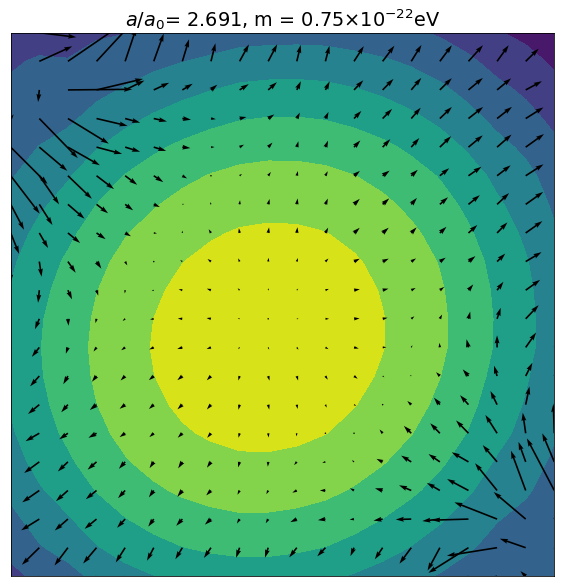

In [322]:
# Choose which saved output number to plot
profile_num = len(facs) - 1
# Choose which ULDM particle mass (0, 1, 2, 3, 4) --> facs = [1.0, 2.5, 5.0, 7.5, 10.0]
mss = 1
# Choose size of plot - number of gridpoints per side
num_pts = 20
# Choose whether to overlay density contours
overlay = True

sf = np.load('{}{}'.format(locs[mss], '/scalefactorlist.npy')).tolist()
a0 = sf[0]
a_f = sf[profile_num]
gridspace = 10/256.
psi = np.load('{}{}{}{}'.format(locs[mss], '/psi_#', profile_num, '.npy'))
rho = abs(psi**2)
centre = (np.unravel_index(np.argmax(rho), rho.shape))
resol = np.shape(psi[0])[0]

xplane = psi[centre[0], :, :]
yplane = psi[:, centre[1], :]
zplane = psi[:, :, centre[2]]

plane = xplane
# plane = yplane
# plane = zplane
rho_plane = np.abs(yplane) ** 2
theta = np.arcsin(np.imag(plane)/np.abs(plane))
ry = np.zeros((256,256))
rz = np.zeros((256,256))
for i in range(256):
    for j in range(256):
        ry[i,j] = (i - centre[1]) * gridspace
        rz[i,j] = (j - centre[2]) * gridspace
        # ry[i,j] = (i - centre[0]) * gridspace
        # rz[i,j] = (j - centre[2]) * gridspace
        # ry[i,j] = (i - centre[0]) * gridspace
        # rz[i,j] = (j - centre[1]) * gridspace

dy_theta = np.zeros((256,256))
dz_theta = np.zeros((256,256))
for i in range(1, 255):
    for j in range(1, 255):
        dy_theta[i,j] = (theta[i+1, j] - theta[i-1, j])/(2 * gridspace)
        dz_theta[i,j] = (theta[i, j+1] - theta[i, j-1])/(2 * gridspace)

Lx = (ry * dz_theta - rz * dy_theta) * rho_plane
log_abs = np.log(np.abs(Lx))



sz = num_pts
tr = (256 - sz)/2
plt.figure(figsize=(10,10))
if overlay == True:
    # Overlay with contour
    trunc = np.zeros((sz,sz))
    for i in range(sz):
        for j in range(sz):
            trunc[i,j] = np.log(rho_plane[i+tr, j+tr])
    plt.contourf(trunc)
n = sz
X, Y = np.mgrid[0:n, 0:n]
U = dy_theta[X+tr, Y+tr]
V = dz_theta[X+tr, Y+tr]
plt.axes().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlim(0,sz-1)
plt.ylim(0,sz-1)
plt.title('{}{}{}{}{}'.format('$a/a_0$= ', np.round(a_f/a0,3), ', m = ', facs[mss], '$\\times 10^{-22}$eV'))
plt.quiver(X, Y, U, V)
plt.show()

# Phase gradient check:

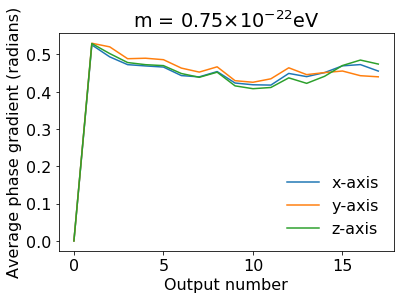

In [323]:
# Choose which ULDM particle mass (0, 1, 2, 3, 4) --> facs = [1.0, 2.5, 5.0, 7.5, 10.0]
mss = 1


sf = np.load('{}{}'.format(locs[mss], '/scalefactorlist.npy')).tolist()
num = len(sf)
ax0 = []
ax1 = []
ax2 = []
for i in range(num):
    fil = np.load('{}{}{}{}'.format(locs[mss], '/psi_#', i, '.npy'))
    dim = fil.shape[0] - 1
    while dim > 254:
        for ax in range(3):
            fil = np.delete(fil, dim, ax)
        for ax in range(3):
            fil = np.delete(fil, 0, ax)
        dim = fil.shape[0] - 1
    avs = [np.average(np.abs(np.angle((np.roll(fil, 1, axis=j) / fil)))) for j in range(fil.ndim)]
    ax0.append(avs[0])
    ax1.append(avs[1])
    ax2.append(avs[2])

plt.tight_layout()
plt.plot(ax0, label='x-axis')
plt.plot(ax1, label='y-axis')
plt.plot(ax2, label='z-axis')
plt.ylabel('Average phase gradient (radians)')
plt.xlabel('Output number')
plt.title('{}{}{}'.format('m = ', facs[mss], '$\\times 10^{-22}$eV'))
plt.legend(frameon=False)
plt.show()


In [ ]:

# Test at higher resolution on my machine
# Need to reset save number and timestep to do full run with proper temporal res

#diff rot
#diff shape
